# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [11]:
# Your code here
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv('../data/boston_data.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

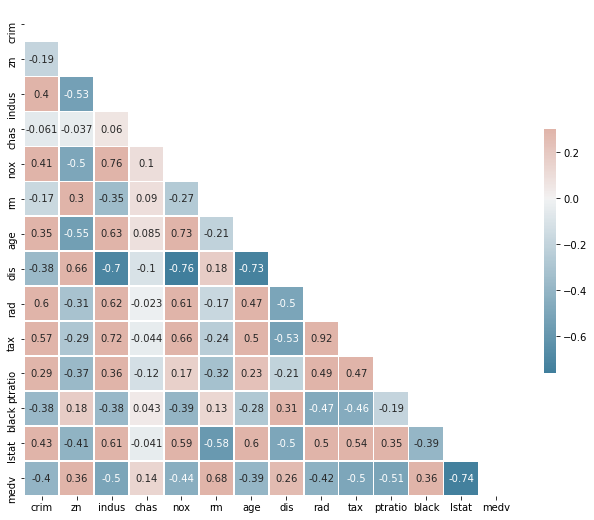

In [13]:
# Your plots here

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [ ]:
'''
the variables with the highest correlation with medv are:
lstat, ptratio, indus, tax, rm
'''

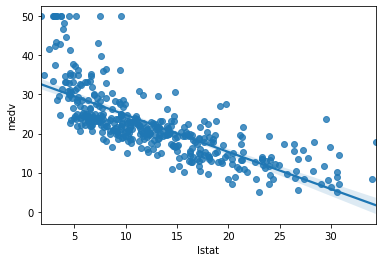

In [23]:
sns.regplot(x='lstat', y='medv', data=df)

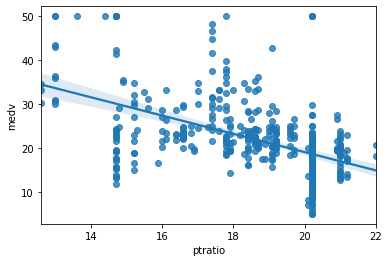

In [24]:
sns.regplot(x='ptratio', y='medv', data=df)

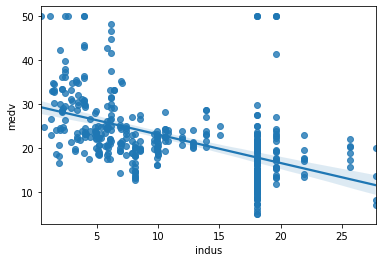

In [25]:
sns.regplot(x='indus', y='medv', data=df)

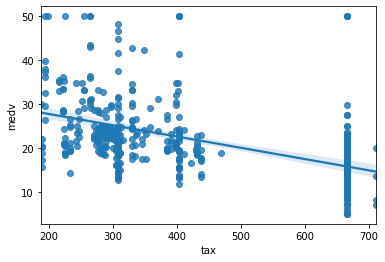

In [26]:
sns.regplot(x='tax', y='medv', data=df)

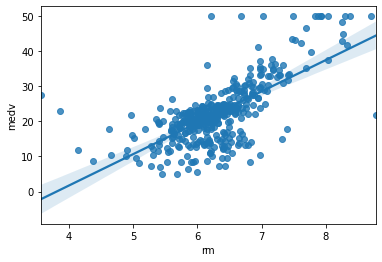

In [27]:
sns.regplot(x='rm', y='medv', data=df)

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [ ]:
# Your response here
'''
Higher lstat, ptratio, indus, tax negatively impact medv.
The reverse is true for rm.

Checking the documentation of the dataset
https://www.kaggle.com/vikrishnan/boston-house-prices

- CRIM per capita crime rate by town 
- ZN proportion of residential land zoned for lots over 25,000 sq.ft. 
- INDUS proportion of non-retail business acres per town 
- CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
- NOX nitric oxides concentration (parts per 10 million) 
- RM average number of rooms per dwelling 
- AGE proportion of owner-occupied units built prior to 1940 
- DIS weighted distances to five Boston employment centres 
- RAD index of accessibility to radial highways 
- TAX full-value property-tax rate per $10,000
     - The full value tax rate represents the estimated tax rate for a municipality if all the taxable 
       property was assessed at 100% and includes the equalized value of properties for which a payment 
       in lieu of property taxes is made.
- PTRATIO pupil-teacher ratio by town 
- B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
- LSTAT % lower status of the population (Proportion of population that is lower status) 
- MEDV Median value of owner-occupied homes in $1000's

I would expect higher tax would go hand to hand with higher property value. Maybe there's a ceiling on property tax? 
Maybe there are other variables that affect how much a property is taxed other than value?

The rest of the variables make sense to me.

'''

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

In [ ]:
# Your response here
'''
rad and nox have a weaker negative correlation (I made the correlation matrix before)
'''

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [29]:
# Your code here

df['medv'].describe()

count    404.000000
mean      22.312376
std        8.837019
min        5.000000
25%       17.100000
50%       21.400000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [30]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # Your code here:
    return r2_score(y_true, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [32]:
# Your code here
from sklearn.model_selection import train_test_split
X = df.drop(columns='medv')
y = df['medv']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 1)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [35]:
# Five separate RFR here with the given max depths
from sklearn.tree import DecisionTreeRegressor

max_depths = [2,4,6,8,10]
models =[]

for d in max_depths: 
    tree = DecisionTreeRegressor(max_depth=d, random_state=1) # fixing random state because I'm a chicken and terrified that random variation screws up my example
    tree.fit(X_train, y_train)
    #tree.score(X_test,y_test)
    models.append(tree)

Now, plot the score for each tree on the training set and on the testing set.

[2, 4, 6, 8, 10]
[0.5627798190417723, 0.6925723357932538, 0.6655247520126639, 0.6298168438325102, 0.5884596386599452]


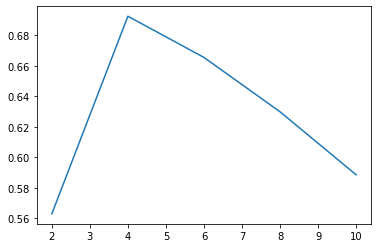

In [37]:
# Produce a plot with the score for the testing and training for the different max depths
r2_scores = []
for m in models:
    y_predict = m.predict(X_test)
    r2_scores.append(performance_metric(y_test, y_predict))
print(max_depths)
print(r2_scores)

sns.lineplot(x=max_depths, y=r2_scores)


What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [ ]:
# Your response here
# there's an optimal depth, and then the performance decreases, probably due to overfitting

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? Check out this article before answering: https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

In [ ]:
# Your response here
'''
With a depth of 1, the model will be underfitting, and will have high bias, and low variance.
With a depth of 1, the model will be overfitting, and will have low bias, and high variance.
There is a tradeoff between bias and variance, the optimal balance will lead to low bias and low variance.
A baised model fails a lot of predictions.
A model with high variance is overfitted and will not be able to generalize well on training data.
'''

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

[3, 4, 5, 6]
[0.6673707023269363, 0.6925723357932538, 0.6525785564203446, 0.6655247520126639]


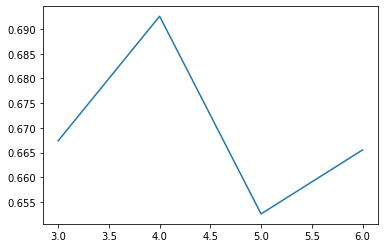

In [38]:
# Your response here
# somewhere between 3 and 6

max_depths = [3,4,5,6]
models =[]

for d in max_depths: 
    tree = DecisionTreeRegressor(max_depth=d, random_state=1) # fixing random state because I'm a chicken and terrified that random variation screws up my example
    tree.fit(X_train, y_train)
    #tree.score(X_test,y_test)
    models.append(tree)

# Produce a plot with the score for the testing and training for the different max depths
r2_scores = []
for m in models:
    y_predict = m.predict(X_test)
    r2_scores.append(performance_metric(y_test, y_predict))
print(max_depths)
print(r2_scores)

sns.lineplot(x=max_depths, y=r2_scores)

In [ ]:
# best depth seems to be 4
# after 4 the model starts to overfit 
# R^2 is 69,3% at max_depth = 4, we can explain 69% of the variance in the Median value of owner-occupied homes 
# with our model.

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [ ]:
# Your response here
# the model is not praticularly accurate on the test data, I won't expect it to generalize well in other areas of the us,
# much less to work well across time